In [29]:
from itertools import product

import numpy as np, pandas as pd
from copy import copy
import seaborn as sns
import hashlib
%load_ext rpy2.ipython
%matplotlib inline
import matplotlib.pyplot as plt

import rpy2.robjects as rpy
from rpy2.robjects import numpy2ri

from traitlets import (Bool,
                       Integer,
                       Unicode,
                       Float,
                       Instance)

### selectinf imports

from selectinf.algorithms.lasso import lasso, ROSI as ROSI_lasso
from selectinf.randomized.lasso import lasso as rand_lasso

### local imports

from instances import AR_instance
from utils import (gaussian_setup,
                   get_method_params)
                   
from gaussian_methods import (lasso_theory,
                              ROSI_theory,
                              randomized_lasso) # we will explicitly write out the classes
                                                # here, inheriting from ROSI_theory
from statistics import interval_statistic, estimator_statistic


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## Fetch simulation code from `bestsubset`

In [30]:
%%R
source("https://raw.githubusercontent.com/ryantibs/best-subset/master/bestsubset/R/common.R")
source("https://raw.githubusercontent.com/ryantibs/best-subset/master/bestsubset/R/sim.R")


In [31]:

def simulate(n=500,
             p=100,
             nval=500,
             s=10,
             rho=0.35,
             beta_type=1,
             snr=0.2):

    numpy2ri.activate()
    r_simulate = rpy.globalenv['sim.xy']
    sim = r_simulate(n, p, nval, rho, s, beta_type, snr)
    X = np.array(sim.rx2('x'))
    y = np.array(sim.rx2('y'))
    
    X -= X.mean(0)[None, :]
    X /= (X.std(0)[None, :] * np.sqrt(n / (n - 1)))
    y = y - y.mean()
    
    X_val = np.array(sim.rx2('xval'))
    y_val = np.array(sim.rx2('yval'))
    Sigma = np.array(sim.rx2('Sigma'))
    beta = np.array(sim.rx2('beta'))
    noise_sd = np.array(sim.rx2('sigma')).reshape(())
    numpy2ri.deactivate()
    return X, y, Sigma, beta, noise_sd



### Extract $\lambda$ and point estimate from `glmnet`

In [32]:
%%R
library(glmnet)
glmnet_LASSO = function(X, y, lambda){                                            
    y = as.numeric(y)                                                                 
    X = as.matrix(X)                                                                 
    lam = as.matrix(lambda)[1,1]                                                     
    n = nrow(X)                                                                      
                                                                                                 
    fit = glmnet(X, y, standardize=FALSE, intercept=FALSE, thresh=1.e-10)             
    estimate.theory = coef(fit, s=lam, exact=TRUE, x=X, y=y)[-1]                            
    fit.cv = cv.glmnet(X, y, standardize=FALSE, intercept=FALSE, thresh=1.e-10)       
    estimate.1se = coef(fit, s=fit.cv$lambda.1se, exact=TRUE, x=X, y=y)[-1]            
    estimate.min = coef(fit, s=fit.cv$lambda.min, exact=TRUE, x=X, y=y)[-1]            
    return(list(estimate.theory=estimate.theory, 
                estimate.1se=estimate.1se, 
                estimate.min=estimate.min, 
                lam.min=fit.cv$lambda.min, 
                lam.1se=fit.cv$lambda.1se))                            
}
    

In [33]:
def glmnet_setup(X, 
                 y, 
                 full_dispersion=True):

    n, p = X.shape
    if full_dispersion:
        dispersion = np.linalg.norm(y - X.dot(np.linalg.pinv(X).dot(y))) ** 2 / (n - p)
        sigma_ = np.sqrt(dispersion)
    else:
        dispersion = None
        sigma_ = np.std(y)

    lam_theory = sigma_ * 1. * np.mean(np.fabs(np.dot(X.T,
                        np.random.standard_normal((n,
                                                   2000)))).max(0)) / n
    
    numpy2ri.activate()
    lambda_R = rpy.globalenv['glmnet_LASSO']
    n, p = X.shape
    r_X = rpy.r.matrix(X, nrow=n, ncol=p)
    r_y = rpy.r.matrix(y, nrow=n, ncol=1)
    r_lam = rpy.r.matrix(lam_theory/float(n), nrow=1, ncol=1)

    val = lambda_R(r_X, r_y, r_lam)
    estimate_theory = np.array(val.rx2('estimate.theory'))
    estimate_1se = np.array(val.rx2('estimate.1se'))
    estimate_min = np.array(val.rx2('estimate.min'))
    lam_min = np.array(val.rx2('lam.min'))[0]
    lam_1se = np.array(val.rx2('lam.1se'))[0]
    numpy2ri.deactivate()
    return estimate_theory, estimate_1se, estimate_min, lam_theory, lam_1se, lam_min

## Make an instance generator from `sim.xy`

In [34]:

class best_subset_data(AR_instance):
    
    instance_name = Unicode('Best Subset (R)')
    n = Integer(500)
    nval = Integer(500)
    p = Integer(100)
    s = Integer(20)
    rho = Float(0.35)
    l_theory = Float()
    feature_cov = Instance(np.ndarray)
    snr = Float(0.2)
    noise = Float(1.)
    beta_type = Integer(1)

    def generate_X(self):
        
        X = simulate(n=self.n,
                     p=self.p,
                     nval=self.nval,
                     rho=self.rho,
                     s=self.s,
                     beta_type=self.beta_type,
                     snr=self.snr)[0]

        return X

    def generate(self):
        
        (X,
         Y,
         Sigma,
         beta,
         noise_sd) = simulate(n=self.n,
                              p=self.p,
                              nval=self.nval,
                              rho=self.rho,
                              s=self.s,
                              beta_type=self.beta_type,
                              snr=self.snr)
        self.feature_cov = Sigma 
        
        self._beta = beta
        Y = X.dot(self._beta) + noise_sd * np.random.standard_normal(self.n)
        return X, Y, self._beta

instance = best_subset_data(n=500, p=100, nval=100, s=5, rho=0.35)
X, Y = instance.generate()[:2]



### Implementation of Liu, Markovic and Tibshirani

In [35]:
  
class ROSI(ROSI_theory):
    
    sigma_estimator = Unicode('relaxed')
    method_name = Unicode("Full (Nonrandom)")
    lambda_choice = Unicode("CV")
    model_target = Unicode("debiased")
    dispersion = Float(0.)
    approximate_inverse = Unicode('BN')
    estimator = Unicode("OLS")

    def __init__(self, X, Y, l_theory, l_min, l_1se, sigma_reid):

        ROSI_theory.__init__(self, X, Y, l_theory, l_min, l_1se, sigma_reid)
        n, p = X.shape
        self.lagrange = l_min * np.ones(X.shape[1])

    @property
    def method_instance(self):
        if not hasattr(self, "_method_instance"):
            n, p = self.X.shape
            self._method_instance = ROSI_lasso.gaussian(self.X,
                                                        self.Y,
                                                        self.lagrange * n,
                                                        approximate_inverse=self.approximate_inverse)
        return self._method_instance
    

### Implementation of Lee et al.

In [36]:
class Lee(lasso_theory):
    
    sigma_estimator = Unicode('relaxed')
    method_name = Unicode("Nonrandom")
    lambda_choice = Unicode("CV")
    model_target = Unicode("selected")
    estimator = Unicode("LASSO")
    
    def __init__(self, X, Y, l_theory, l_min, l_1se, sigma_reid):

        lasso_theory.__init__(self, X, Y, l_theory, l_min, l_1se, sigma_reid)
        n, p = X.shape
        self.lagrange = l_min * np.ones(X.shape[1])
        self.dispersion = np.linalg.norm(Y - X.dot(np.linalg.pinv(X).dot(Y))) ** 2 / (n - p)
        
    @property
    def method_instance(self):
        if not hasattr(self, "_method_instance"):
            n, p = self.X.shape
            self._method_instance = lasso.gaussian(self.X,
                                                   self.Y,
                                                   self.lagrange * n)
        return self._method_instance
 

### Implementation of naive method

In [37]:
class Naive(Lee):
    
    method_name = Unicode("Naive")
    
    def generate_summary(self, compute_intervals=True):
        if not self._fit:
            self.method_instance.fit()
            self._fit = True

        X, Y, lagrange, L = self.X, self.Y, self.lagrange, self.method_instance
        n, p = X.shape
        
        if len(L.active) > 0:
            S = L.summary(compute_intervals=False)
            lower, upper = self.naive_intervals(L.active)[1:3]
            pvalue = self.naive_pvalues(L.active)[1]
            return pd.DataFrame({'variable':L.active,
                                 'upper_confidence':upper,
                                 'lower_confidence':lower,
                                 'onestep':S['onestep'],
                                 'lasso':S['lasso'],
                                 'pvalue':pvalue})
    
    def generate_pvalues(self):
        S = self.generate_summary()
        if S is not None:
            return np.array(S['variable']), np.array(S['pvalue'])
        else:
            return [], []
        
    def generate_intervals(self):
        S = self.generate_summary()
        if S is not None:
            return (np.array(S['variable']), 
                    np.array(S['lower_confidence']), 
                    np.array(S['upper_confidence']), 
                    np.array(S['pvalue']))
        else:
            return [], [], [], []

### Implementation of randomized LASSO

In [38]:
class Randomized(randomized_lasso):

    use_MLE = Bool(False)
    randomizer_scale = Float(np.sqrt(0.25))
    method_name = Unicode("Randomized")
    lambda_choice = Unicode('1se')
    use_initial_soln = Bool(True)
    
    def __init__(self, X, Y, l_theory, l_min, l_1se, sigma_reid):

        randomized_lasso.__init__(self, X, Y, l_theory, l_min, l_1se, sigma_reid)
        n, p = X.shape
        self.lagrange = l_1se * np.ones(X.shape[1])
        self.dispersion = np.linalg.norm(Y - X.dot(np.linalg.pinv(X).dot(Y))) ** 2 / (n - p)
           
    @property
    def method_instance(self):
        if not hasattr(self, "_method_instance"):
            n, p = self.X.shape
            sigma_ = np.sqrt(self.dispersion)

            self._method_instance = rand_lasso.gaussian(self.X,
                                                        self.Y,
                                                        self.lagrange * n,
                                                        randomizer_scale=(
                                                        np.sqrt(n) * sigma_ * self.randomizer_scale))
        return self._method_instance
    
    def point_estimator(self):
        active, soln = randomized_lasso.point_estimator(self)
        if self.use_initial_soln:
            soln = self.method_instance.initial_soln
        return active, soln

### Implementation of selective MLE

In [39]:
class MLE(Randomized):
    method_name = Unicode("MLE")
    use_MLE = Bool(True)
    use_initial_soln = Bool(False)
  

## Run a simulation collecting results

In [40]:
  
methods = [Lee, Naive, MLE, Randomized]
for method in methods:
    method.setup(instance.feature_cov, instance)
method_params, class_names, method_names = get_method_params(methods)

palette = {'MLE': 'blue',
           'Naive': 'red',
           'Nonrandom': 'orange',
           'Randomized': 'purple'}

In [41]:
nsim = 20
snrs = [0.15, 0.2, 0.31]

results = []
for i, snr in product(range(nsim),
                      snrs):                                                                            

    instance.snr = snr                                                                                             
    X, Y, beta = instance.generate()                                                             
                                                                                                 
    # make a hash representing same data                                                         
                                                                                                 
    instance_hash = hashlib.md5()                                                                
    instance_hash.update(X.tobytes())                                                            
    instance_hash.update(Y.tobytes())                                                            
    instance_hash.update(beta.tobytes())                                                         
    instance_id = instance_hash.hexdigest()                                                      

    (glm_LASSO_theory,
     glm_LASSO_1se,
     glm_LASSO_min,
     lam_theory,
     lam_1se,
     lam_min) = glmnet_setup(X,
                             Y,
                             full_dispersion=True)

    for method, method_name, class_name, idx in zip(methods,                                     
                                                    method_names,                                
                                                    class_names,                                 
                                                    range(len(methods))):                        
        
        M, result_df = interval_statistic(method,
                                          instance,
                                          X.copy(),
                                          Y.copy(),
                                          beta.copy(),
                                          copy(lam_theory),
                                          copy(lam_min),
                                          copy(lam_1se),
                                          None)
        
        if result_df is not None:
            
            result_df['instance_id'] = copy(instance_id)
            result_df['method_param'] = str(method_params.loc[idx])
            result_df['model_target'] = M.model_target
            result_df['method_name'] = method_name
            result_df['class_name'] = class_name
            
            _, estimator_df = estimator_statistic(method,
                                                  instance,
                                                  X.copy(),
                                                  Y.copy(),
                                                  beta.copy(),
                                                  copy(lam_theory),
                                                  copy(lam_min),
                                                  copy(lam_1se),
                                                  None,
                                                  M=M)
            for p in instance.params.columns:
                result_df[p] = instance.params[p][0]
            result_df['confidence'] = M.confidence

            for col in estimator_df.columns:
                if col not in result_df.columns:
                    result_df.insert(1, col, estimator_df[col][0] * np.ones(result_df.shape[0]))
            results.append(result_df)

In [42]:
all_results = pd.concat(results)
outfile = 'selected_target_results.csv'
all_results.to_csv(outfile, index=False)

## Risk

In [43]:
risk_results = []
risk_names = sorted([n for n in all_results.columns if 'Risk' in n])
for key, df in all_results.groupby(['instance_id', 'method_name', 'snr']):
    risk_results.append(list(key[1:]) + [df[n].mean() for n in risk_names])
risk_results = pd.DataFrame(risk_results, columns=['method_name', 'snr'] + risk_names)

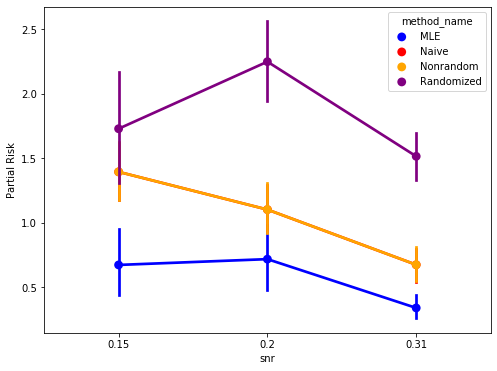

In [44]:
plt.figure(figsize=(8, 6))
sns.pointplot(x='snr',
              y='Partial Risk',
              hue='method_name',
              data=risk_results,
              palette=palette)

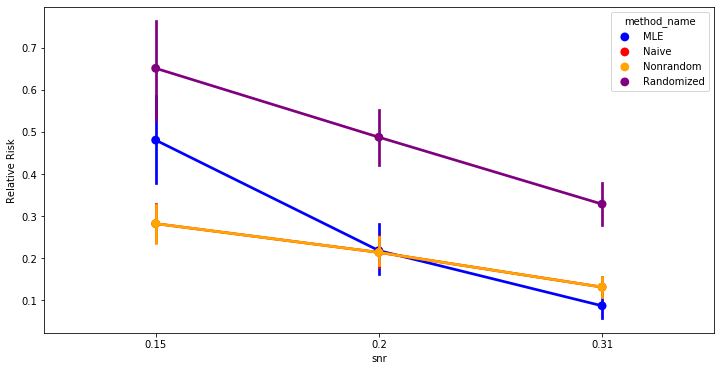

In [45]:
plt.figure(figsize=(12, 6))
sns.pointplot(x='snr',
              y='Relative Risk',
              hue='method_name',
              data=risk_results,
              palette=palette)

## Intervals

In [46]:
interval_results = []
for key, df in all_results.groupby(['instance_id', 'method_name', 'snr']):
    if key[1] != 'Randomized':
        covered = ((df['lower_confidence'] <= df['target']) & 
                   (df['upper_confidence'] >= df['target']))
        length = df['upper_confidence'] - df['lower_confidence']
        interval_results.append(list(key[1:]) + [np.mean(covered), np.median(length)])
interval_results = pd.DataFrame(interval_results, columns=['method_name', 'snr'] + ['Coverage', 'Length'])


(-0.5, 2.5)

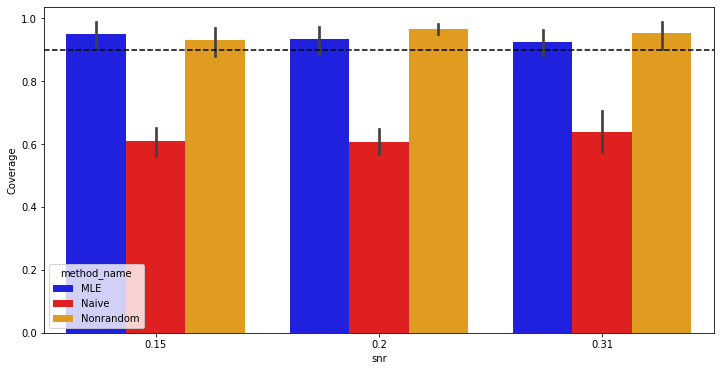

In [47]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='snr',
                 y='Coverage',
                 hue='method_name',
                 data=interval_results,
                 palette=palette)
xlim = ax.get_xlim()
ax.plot(xlim, [all_results['confidence'].mean()]*2, 'k--')
ax.set_xlim(xlim)

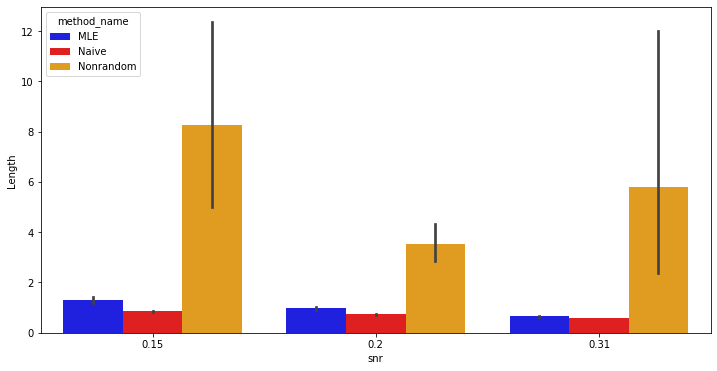

In [48]:
plt.figure(figsize=(12, 6))
sns.barplot(x='snr',
            y='Length',
            hue='method_name',
            data=interval_results,
            palette=palette)

## Power

In [49]:
test_level = 0.1
power_results = []
for key, df in all_results.groupby(['instance_id', 'method_name', 'snr']):
    alt_df = df[lambda df: df['target'] != 0]
    power_results.append(list(key[1:]) + [np.mean(alt_df['pvalue'] < test_level)])
power_results = pd.DataFrame(power_results, columns=['method_name', 'snr'] + ['Selective Power'])


(0, 1)

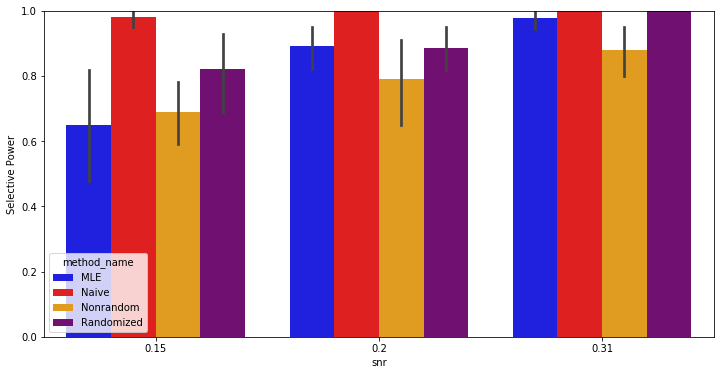

In [55]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='snr',
                 y='Selective Power',
                 hue='method_name',
                 data=power_results,
                 palette=palette)
ax.set_ylim([0,1.1])

### Power when selecting on `full_target`

In [51]:
test_level = 0.1
power_results = []
for key, df in all_results.groupby(['instance_id', 'method_name', 'snr']):
    alt_df = df[lambda df: df['full_target'] != 0]
    power_results.append(list(key[1:]) + [np.mean(alt_df['pvalue'] < test_level)])
power_results = pd.DataFrame(power_results, columns=['method_name', 'snr'] + ['Selective Power'])


(0, 1)

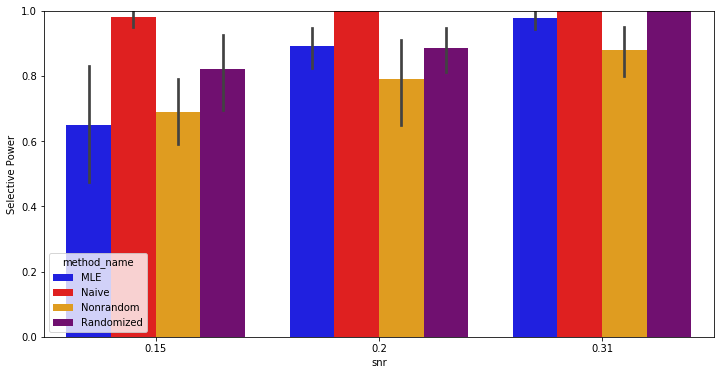

In [56]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='snr',
                 y='Selective Power',
                 hue='method_name',
                 data=power_results,
                 palette=palette)
ax.set_ylim([0, 1.1])

## Selective Type I Error

In [53]:
size_results = []
for key, df in all_results.groupby(['instance_id', 'method_name', 'snr']):
    null_df = df[lambda df: df['full_target'] == 0]
    size_results.append(list(key[1:]) + [np.nanmean(null_df['pvalue'] < test_level)])
size_results = pd.DataFrame(size_results, columns=['method_name', 'snr'] + ['Selective Type I Error'])


(-0.5, 2.5)

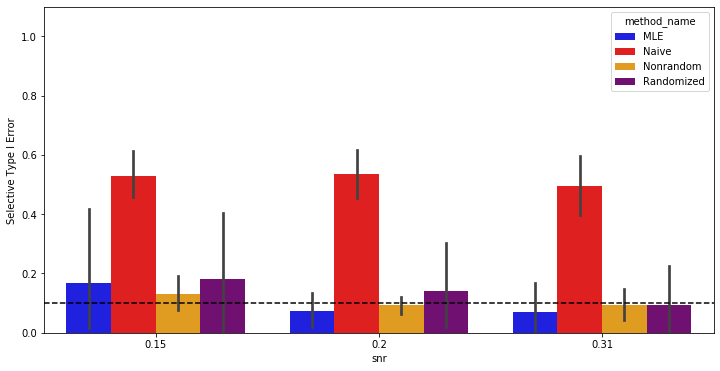

In [58]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='snr',
                 y='Selective Type I Error',
                 hue='method_name',
                 data=size_results,
                 palette=palette)
ax.set_ylim([0, 1.1])
xlim = ax.get_xlim()
ax.plot(xlim, [test_level]*2, 'k--')
ax.set_xlim(xlim)